## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Create title and Upload file with Pandas

In [2]:
title = ["UserId","MovieId","Rate","TimeStamp"]
df = pd.read_csv("ml-100k/u.data",sep="\t",names=title)

In [3]:
userNum = df.UserId.unique().shape[0]
movieNum = df.MovieId.unique().shape[0]

In [4]:
print("User number: " + str(userNum) + "\nMovie number: " + str(movieNum))

User number: 943
Movie number: 1682


In [5]:
df.head()

,UserId,MovieId,Rate,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Draw Rate Distrubition with Matplotlib

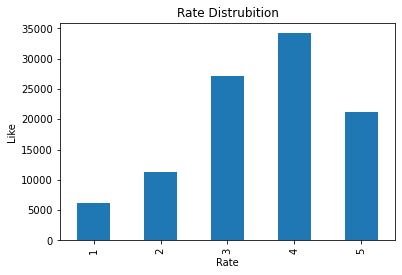

In [6]:
plt.rc("font",size = 10)
df.Rate.value_counts(sort = False).plot(kind = "bar")
plt.title("Rate Distrubition")
plt.xlabel("Rate")
plt.ylabel("Like")
plt.show()

In [7]:
dfAvg = pd.DataFrame(round(df.groupby("MovieId")["Rate"].mean(),2))
dfAvg["DsTemp"] = pd.DataFrame(round(df.groupby("MovieId")["Rate"].count()))
dfAvg.columns = ["RateAverage","RateNum"]
dfAvg.sort_values("RateNum",ascending = False).head()

,RateAverage,RateNum
MovieId,,
50,4.36,583
258,3.80,509
100,4.16,508
181,4.01,507
294,3.16,485


### We can use the most recommendation method in here which name is collaborative filtering

In [8]:
userProductMatrices = np.zeros((userNum,movieNum))
for line in df.itertuples():
    userProductMatrices[line[1]-1,line[2]-1] = line[3]
    
userProductMatrices.shape

(943, 1682)

### After that we can calculate similarity in users so we should use cosine rule

In [9]:
from sklearn.metrics.pairwise import pairwise_distances

userSimilarity = pairwise_distances(userProductMatrices,metric = "cosine")
userSimilarity.shape

(943, 943)

### We calculate similarity, now on we can predict

In [10]:
def predict(rate,similarity):
    averageRate = rate.mean(axis = 1)
    
    rateSubstract = (rate-averageRate[:,np.newaxis])
    
    predict = averageRate[:,np.newaxis] + similarity.dot(rateSubstract) / np.array([np.abs(similarity).sum(axis = 1)]).T
    
    return predict

In [11]:
userPredict = predict(userProductMatrices,userSimilarity)

In [12]:
userPredict

array([[ 2.06532606,  0.73430275,  0.62992381, ...,  0.39359041,
         0.39304874,  0.3927712 ],
       [ 1.76308836,  0.38404019,  0.19617889, ..., -0.08837789,
        -0.0869183 , -0.08671183],
       [ 1.79590398,  0.32904733,  0.15882885, ..., -0.13699223,
        -0.13496852, -0.13476488],
       ...,
       [ 1.59151513,  0.27526889,  0.10219534, ..., -0.16735162,
        -0.16657451, -0.16641377],
       [ 1.81036267,  0.40479877,  0.27545013, ..., -0.00907358,
        -0.00846587, -0.00804858],
       [ 1.8384313 ,  0.47964837,  0.38496292, ...,  0.14686675,
         0.14629808,  0.14641455]])

### Calculate Rarity

In [13]:
rarity = round(1.0 - len(df) / float(userNum * movieNum),4)

In [14]:
rarity #It means that our dataset is so rarity

0.937

### Singular value decomposition

That is matrices seperation method. And that formula is X = U * S * V

U: mxr orthogonal matrices

S: rxr diagonal matrices

V: rxn orthogonal matrices

In [15]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

U,S,V = svds(userProductMatrices,k = 30)
U.shape

(943, 30)

We can see that U matrices dimensions decrease.

### Now on we can work on RMSE(Root Mean Square Error)

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def calculateRmse(predict,referenceVariable):
    predict = predict[referenceVariable.nonzero()].flatten()
    referenceVariable = referenceVariable[referenceVariable.nonzero()].flatten()
    return sqrt(mean_squared_error(predict, referenceVariable))

### Train and Test cluster decomposition

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(df,test_size = 0.33)

### Build Train and Test matrices

In [18]:
userProductMatricesTrain = np.zeros((userNum,movieNum))
for line in X_train.itertuples():
    userProductMatricesTrain[line[1]-1,line[2]-1] = line[3]
userProductMatricesTest = np.zeros((userNum,movieNum))
for line in X_test.itertuples():
    userProductMatricesTest[line[1]-1,line[2]-1] = line[3]

### Calculate similarity and invoke predict function

In [19]:
userSimilarity = pairwise_distances(userProductMatricesTrain,metric = "cosine")
userPredict = predict(userProductMatricesTrain,userSimilarity)

### RMSE before SVD

In [20]:
calculateRmse(userPredict,userProductMatricesTest)

3.17208135963813

### RMSE after SVD

In [21]:
U,S,V = svds(userProductMatricesTrain,k=30)
SDiagMatrices = np.diag(S)
SVDPredict = np.dot(np.dot(U,SDiagMatrices),V)
calculateRmse(SVDPredict,userProductMatricesTest)

2.9080703641241863